In [50]:
cd Desktop/workBench/

[Errno 2] No such file or directory: 'Desktop/workBench/'
/Users/ShivamDhall/Desktop/workBench


In [51]:
import subprocess
import pandas as pd
import numpy as np
import random
import os
import time
import progressbar
import matplotlib.pyplot as plt
import math

## Generating Data

In [3]:
#fuction for generating the sythesised MRI signals

def genData(modelsDict, schemeFileLoc, fileName, iterations, groundTruthNames):
    argsList = ["datasynth", "-synthmodel", "compartment"]
    numberOfCompartments = len(modelsDict)
    argsList.append(numberOfCompartments)
    for key in range(numberOfCompartments):
        for value in modelsDict.values()[key]:
            argsList.append(value)
    argsList.extend(("-schemefile", schemeFileLoc, "-voxels", 1, ">", fileName + ".Bfloat", "2>>", fileName + ".log"))
        
    #extra validation
    count = 0
    for value in argsList:
        if type(value) == list:
            count += 1
    if count == 0:
        print "No parameters are being varied"
    if count != len(groundTruthNames):
        print "The number of parameters being varied do not match with the list of columns specifed"
        
    #dataframe used to store the groundtruths in the correct sequence
    groundTruths = pd.DataFrame(np.random.randn(iterations, len(groundTruthNames)), columns = groundTruthNames)
    bar = progressbar.ProgressBar()
    for iteration in bar(range(iterations)):
        args = list(argsList)
        i = 0
        for index, val in enumerate(args):
            if type(val) == list:
                args[index] = random.uniform(val[0], val[1])
                groundTruths.set_value(iteration, groundTruthNames[i], args[index])
                i += 1
            if val == fileName+".Bfloat":
                args[index] = fileName + str(iteration) + ".Bfloat"
            args[index] = str(args[index])
            
        #create a subprocess which calls the command that generates a synthesised MRI signal
        subprocess.call(' '.join(args), shell=True)
        subprocess.call("echo '\n----------\n' >>" + fileName + ".log", shell = True)
    #save groundtruths dataframe as csv file in same loc as .Bfloat files
    groundTruths.to_csv(fileName + "_GroundTruths.csv")
    return groundTruths

In [4]:
#function for converting the .Bfloat files to a 2d numpy-array

def transformData(folderPath):
    
    #create a new datatype that is big-endian and has size of a single-precision float
    dt = np.dtype('>f')
    
    isExec = False
    BFloatFiles = [filename for filename in os.listdir(folderPath) if filename.endswith(".Bfloat")]
    voxelCount = len(BFloatFiles)
    for fileName in BFloatFiles:
        voxArray = np.fromfile(folderPath + "/" + fileName, dtype=dt, sep="")
        if isExec == False:
            finalArray = np.full([voxelCount, len(voxArray)], 0)
            isExec = True
        voxArray = voxArray.reshape((1, voxArray.size))
        
        #get number from fileName
        voxNumber = int(filter(str.isdigit, fileName))
        finalArray[voxNumber] = voxArray
    return finalArray

In [7]:
model1 = { 1: ['Tensor', [0.8E-9, 2.2E-9], 0.0, 0.0, 2.0E-9, 1.4E-9, 0.0]}

#specify the correct location of the scheme file and a generic filename for storing the bfloat files
groundTruths = genData(model1, "PGSE_90.scheme", "./exp1/DT", 1000, ["diffusivity"])

100% (10 of 10) |##########################| Elapsed Time: 0:00:07 Time: 0:00:07 10% ( 1 of 10) |##                         | Elapsed Time: 0:00:02 ETA: 0:00:19


In [63]:
groundTruths = pd.read_csv("./exp1/DT_GroundTruths.csv", index_col = 0)
data = transformData("./exp1")
y = groundTruths[' '.join(groundTruths.columns.tolist())].values
y_scaled = y * 1E9

## Machine Learning 

In [85]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

In [66]:
#we first randomly split the data into a training and testing set of ratio 7:3
np.random.seed(0)
indices = np.random.permutation(len(data))
num = int(len(data)*0.7)
X_train = data[indices[:num]]
y_train = y_scaled[indices[:num]]
X_test  = data[indices[num:]]
y_true  = y_scaled[indices[num:]]

##### Feature Visualisation

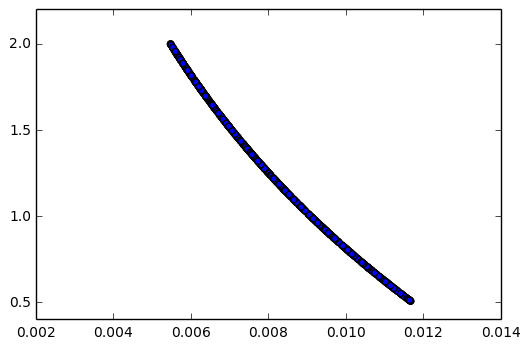

In [67]:
%matplotlib inline
plt.scatter (X_train[:,0], y_train)
#plt.scatter (X_train[:,1], y_train)
#plt.scatter (X_train[:,2], y_train)

### Experiment 1

Model used = Diffusion Tensor  

Parameters being predicted:
- Diffusivity in a single direction

##### Ridge Regression

In [68]:
reg = linear_model.RidgeCV()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [69]:
print "explained varience score: ", metrics.explained_variance_score(y_true, y_pred)
print "mean absolute error: ", metrics.mean_absolute_error(y_true, y_pred)
print "mean squared error: ", metrics.mean_squared_error(y_true, y_pred)
print "r2_score: ", metrics.r2_score(y_true, y_pred) 

explained varience score:  0.999634047601
mean absolute error:  0.00702573996314
mean squared error:  6.80244659874e-05
r2_score:  0.999633739064


##### Random Forest Regression

In [70]:
rfReg = RandomForestRegressor(n_estimators = 1)
rfReg.fit(X_train, y_train)
rfy_pred = rfReg.predict(X_test)

In [72]:
print "explained varience score: ", metrics.explained_variance_score(y_true, rfy_pred)
print "mean absolute error: ", metrics.mean_absolute_error(y_true, rfy_pred)
print "mean squared error: ", metrics.mean_squared_error(y_true, rfy_pred)
print "r2_score: ", metrics.r2_score(y_true, rfy_pred) 

 explained varience score:  0.999974533267
mean absolute error:  0.00157493769052
mean squared error:  4.74419560836e-06
r2_score:  0.99997445605


##### SVM Regression

In [190]:
from sklearn import svm
clf = svm.SVR(kernel='linear')
clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)

In [18]:
print "explained varience score: ", metrics.explained_variance_score(y_true, clf_pred)
print "mean absolute error: ", metrics.mean_absolute_error(y_true, clf_pred)
print "mean squared error: ", metrics.mean_squared_error(y_true, clf_pred)
print "r2_score: ", metrics.r2_score(y_true, clf_pred) 

explained varience score:  0.983122455962
mean absolute error:  0.0632333213983
mean squared error:  0.00492620473448
r2_score:  0.973476067285


##### K-Nearest Neighbors

In [19]:
from sklearn import neighbors
knn = neighbors.KNeighborsRegressor(n_neighbors = 2, weights = "distance")
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

In [20]:
print "explained varience score: ", metrics.explained_variance_score(y_true, knn_pred)
print "mean absolute error: ", metrics.mean_absolute_error(y_true, knn_pred)
print "mean squared error: ", metrics.mean_squared_error(y_true, knn_pred)
print "r2_score: ", metrics.r2_score(y_true, knn_pred) 

explained varience score:  0.999991218579
mean absolute error:  0.000723556305759
mean squared error:  1.63640220315e-06
r2_score:  0.999991189196


In [21]:
y_true

array([ 0.66023671,  1.27733817,  1.72438136,  1.81277436,  1.95465759,
        1.94332413,  1.63777381,  1.55581252,  0.90594993,  0.54602426,
        1.47433408,  1.18693772,  1.11529745,  0.97373485,  0.99570761,
        0.8494733 ,  1.31546439,  0.59738897,  1.75938238,  0.89720076,
        0.77734209,  1.2601013 ,  0.71134949,  0.82636427,  0.85557685,
        1.02438344,  1.57770401,  0.54220987,  1.51525375,  1.10587811,
        0.67460871,  0.67880785,  0.52189314,  1.91045326,  0.63328832,
        1.08114961,  0.8208934 ,  0.75897603,  1.01098802,  0.70436208,
        0.77754572,  0.96602705,  1.47039865,  1.52894745,  1.04761308,
        1.33850179,  1.84057437,  1.5291857 ,  1.51465309,  1.41358677,
        1.38555981,  1.96299677,  1.92964976,  1.04486216,  1.68791658,
        1.97591047,  0.62210907,  1.50897047,  1.31494479,  0.88858181,
        1.51606727,  1.92133206,  1.30988479,  0.80499989,  0.88988818,
        1.51952413,  1.57865651,  0.99875512,  0.59276484,  1.02

In [22]:
knn_pred

array([ 0.6602379 ,  1.27733829,  1.72446284,  1.81150244,  1.95483132,
        1.94389897,  1.63777573,  1.5558126 ,  0.90785212,  0.54595806,
        1.47433482,  1.18605761,  1.11529789,  0.9737357 ,  0.99506858,
        0.85092498,  1.31546445,  0.59684839,  1.7584961 ,  0.89645509,
        0.77734425,  1.25822566,  0.70657055,  0.82733074,  0.85557736,
        1.02671175,  1.57776285,  0.54220988,  1.5162778 ,  1.10588266,
        0.67322462,  0.68176095,  0.52242798,  1.91045329,  0.63328848,
        1.07943609,  0.82034853,  0.75607336,  1.01098834,  0.70500839,
        0.77754794,  0.96602766,  1.47072565,  1.52984208,  1.04761363,
        1.34099918,  1.84057469,  1.52984202,  1.51465346,  1.41280507,
        1.38724788,  1.96299931,  1.9319553 ,  1.04582229,  1.68791666,
        1.97661704,  0.6198235 ,  1.50897214,  1.3153484 ,  0.88858522,
        1.51606728,  1.92062426,  1.31036942,  0.80552279,  0.89205836,
        1.51897377,  1.57780497,  1.00073734,  0.59276485,  1.02

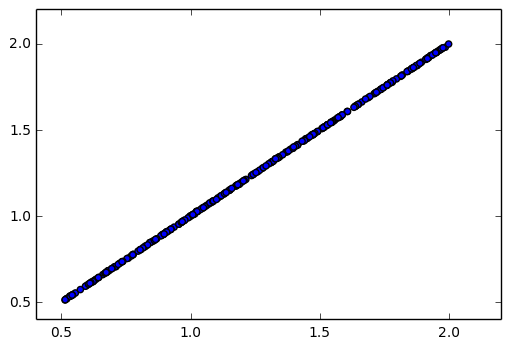

In [24]:
%matplotlib inline
plt.scatter(y_true, knn_pred)

### Experiment 2

Model used = Diffusion Tensor    

Parameters being predicted: 
- Diffusivity in three directions

In [23]:
model2 = { 1: ['Tensor', [0.8E-9, 2.2E-9], 0.0, 0.0, [0.8E-9, 2.2E-9], [0.8E-9, 2.2E-9], 0.0]}

#specify the correct location of the scheme file and a generic filename for storing the bfloat files
groundTruths2 = genData(model2, "PGSE_90.scheme", "./exp2/DT", 100, ["d1", "d2", "d3"])

100% (100 of 100) |#############################################| Elapsed Time: 0:00:55 Time: 0:00:55  1% (1 of 100) |                                                | Elapsed Time: 0:00:02 ETA: 0:03:18


In [24]:
groundTruths2 = pd.read_csv("./exp2/DT_GroundTruths.csv", index_col = 0)
data2 = transformData("./exp2")
y2 = groundTruths2.values * 1E9

In [25]:
np.random.seed(0)
indices = np.random.permutation(len(data2))
num = int(len(data2)*0.7)
X_train2 = data2[indices[:num]]
y_train2 = y2[indices[:num]]
X_test2  = data2[indices[num:]]
y_true2  = y2[indices[num:]]

##### Ridge Regression

In [27]:
reg2 = linear_model.RidgeCV()
reg2.fit(X_train2, y_train2)
y_pred2 = reg2.predict(X_test2)

In [28]:
print "explained varience score: ", metrics.explained_variance_score(y_true2, y_pred2, multioutput='variance_weighted')
print "r2_score: ", metrics.r2_score(y_true2, y_pred2, multioutput='variance_weighted') 

explained varience score:  0.995986583289
r2_score:  0.995843227189


In [29]:
y_true2

array([[ 1.8095335 ,  1.78784883,  1.61180596],
       [ 1.12959741,  2.12442864,  2.04968694],
       [ 1.36354158,  1.38951138,  1.5700255 ],
       [ 1.72748263,  1.54715691,  1.82599956],
       [ 2.06534305,  2.07760061,  2.03028736],
       [ 1.41948268,  1.23287141,  0.9474717 ],
       [ 1.88911142,  0.86325097,  0.90187227],
       [ 1.62863946,  1.83130504,  1.794221  ],
       [ 1.29953153,  0.82177872,  1.50142281],
       [ 0.88233839,  1.55737301,  1.36634095],
       [ 1.66273266,  1.31922579,  1.73607005],
       [ 1.57898092,  0.98603515,  2.01597105],
       [ 1.20086348,  1.0714754 ,  1.99275184],
       [ 2.08325028,  1.04526686,  1.3179162 ],
       [ 1.60833844,  1.88068046,  1.93477796],
       [ 1.93053645,  0.94631466,  1.66392388],
       [ 1.97927596,  1.23214878,  1.07628028],
       [ 1.24081205,  1.60496646,  1.39735447],
       [ 2.14462521,  1.26990798,  1.92361532],
       [ 1.97865795,  1.39054755,  1.59463346],
       [ 0.92351022,  2.11364739,  1.354

In [30]:
y_pred2

array([[ 1.80679543,  1.7954232 ,  1.63684977],
       [ 1.18212122,  2.083819  ,  2.01350902],
       [ 1.37793304,  1.40264347,  1.58088621],
       [ 1.73640209,  1.56907886,  1.83036229],
       [ 2.02591517,  2.03976373,  2.01289328],
       [ 1.43728425,  1.23872611,  0.90515143],
       [ 1.9078611 ,  0.84822803,  0.86827061],
       [ 1.64883153,  1.83195205,  1.79898098],
       [ 1.30668215,  0.78810149,  1.51767677],
       [ 0.86086784,  1.57699875,  1.3721893 ],
       [ 1.67455454,  1.33711105,  1.74861265],
       [ 1.60039578,  0.9873681 ,  2.00975845],
       [ 1.21814686,  1.06823019,  1.98852046],
       [ 2.05402569,  1.05573225,  1.34701475],
       [ 1.63595671,  1.87480604,  1.9209597 ],
       [ 1.91915279,  0.94820732,  1.69364898],
       [ 1.96847829,  1.2507949 ,  1.07869802],
       [ 1.2495798 ,  1.62226373,  1.40305772],
       [ 2.08972978,  1.30985711,  1.93256184],
       [ 1.95363728,  1.41823842,  1.62446188],
       [ 0.92443666,  2.10011111,  1.368

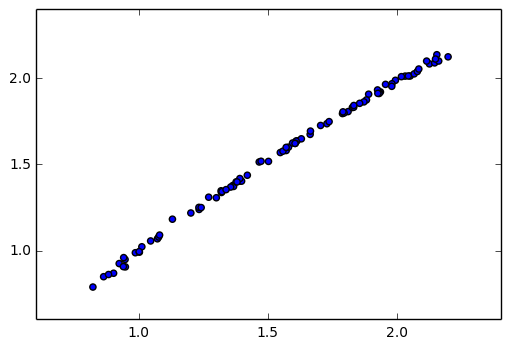

In [31]:
%matplotlib inline
plt.scatter(y_true2, y_pred2)

### Experiment 3

Model used = Ball and stick

Parameters predicted: 
- Intra axonal volume fraction (Stick)
- Intra axonal diffusivity (Stick)  
- Extra axonal diffusivity (Ball)

In [128]:
model3 = { 1: ['Stick', [0.0, 1.0], [0.8E-9, 2.2E-9], 0.0, 0.0], 2: ['Ball', [0.8E-9, 2.2E-9]]}

groundTruths3 = genData(model3, "PGSE_90.scheme", "./exp3/BalAndStick", 1000, ["StickVolumeFraction", "intraD", "extraD"])

100% (1000 of 1000) |###########################################| Elapsed Time: 0:09:33 Time: 0:09:33  0% (1 of 1000) |                                               | Elapsed Time: 0:00:02 ETA: 0:40:13


In [131]:
groundTruths3 = pd.read_csv("./exp3/BalAndStick_GroundTruths.csv", index_col = 0)
data3 = transformData("./exp3")
y3 = groundTruths3.values

In [132]:
#we can use the standard scaler implementation in sklearn to scale the ground-truth valuse before training
y3 = preprocessing.scale(y3)

In [133]:
np.random.seed(0)
indices = np.random.permutation(len(data3))
num = int(len(data3)*0.7)
X_train3 = data3[indices[:num]]
y_train3 = y3[indices[:num]]
X_test3  = data3[indices[num:]]
y_true3  = y3[indices[num:]]

##### Ridge Regression

In [134]:
reg3 = linear_model.RidgeCV()
reg3.fit(X_train3, y_train3)
y_pred3 = reg3.predict(X_test3)

In [135]:
print "explained varience score: ", metrics.explained_variance_score(y_true3, y_pred3, multioutput='variance_weighted')
print "r2_score: ", metrics.r2_score(y_true3, y_pred3, multioutput='variance_weighted') 

explained varience score:  0.831040776089
r2_score:  0.82981067721


##### K-Nearest Neighbors

In [136]:
from sklearn import neighbors
knn3 = neighbors.KNeighborsRegressor(n_neighbors = 2, weights = "distance")
knn3.fit(X_train3, y_train3)
knn_pred3 = knn3.predict(X_test3)

In [137]:
print "explained varience score: ", metrics.explained_variance_score(y_true3, knn_pred3, multioutput='variance_weighted')
print "r2_score: ", metrics.r2_score(y_true3, knn_pred3, multioutput='variance_weighted') 

explained varience score:  0.836158122923
r2_score:  0.836125669877


Below we use a grid search with three fold cross validation to find optimal parameters for the learning algorithm.  
The parameters selected are those that maximise the r<sup>2</sup> score.

In [184]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
grid_parameters = {'n_neighbors':[2,3,4,5,10], 'weights':("uniform", "distance")}
scorer = make_scorer(metrics.r2_score, multioutput="variance_weighted")
knn3_grid = GridSearchCV(neighbors.KNeighborsRegressor(), grid_parameters, scoring=scorer, verbose=1)
knn3_grid.fit(X_train3, y_train3)
print "\nBest Params: ", knn3_grid.best_params_ 
knn3_grid_pred = knn3_grid.predict(X_test3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Params:  {'n_neighbors': 5, 'weights': 'distance'}


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.3s finished


In [185]:
print "explained varience score: ", metrics.explained_variance_score(y_true3, knn3_grid_pred, multioutput='variance_weighted')
print "r2_score: ", metrics.r2_score(y_true3, knn3_grid_pred, multioutput='variance_weighted') 

explained varience score:  0.842031411949
r2_score:  0.841983818256


#####  Random Forests
With grid search and 3-fold cross validation

In [187]:
grid_parameters = {'n_estimators':[5,10,25,50,100], 'max_depth':[20,50,100]}
rfReg = RandomForestRegressor()
rfReg3_grid = GridSearchCV(rfReg, grid_parameters, scoring=scorer, verbose=1)
rfReg3_grid.fit(X_train3, y_train3)
rfReg3_grid_pred = rfReg3_grid.predict(X_test3)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.7min finished


In [196]:
print "\nBest Params: ", knn3_grid.best_params_ 
print "explained varience score: ", metrics.explained_variance_score(y_true3, rfReg3_grid_pred, multioutput='variance_weighted')
print "r2_score: ", metrics.r2_score(y_true3, rfReg3_grid_pred, multioutput='variance_weighted') 
print "r2_score: ", metrics.r2_score(y_true3, rfReg3_grid_pred, multioutput='uniform_average') 


Best Params:  {'n_neighbors': 5, 'weights': 'distance'}
explained varience score:  0.885231671419
r2_score:  0.884807576376
r2_score:  0.885392220677


In [194]:
rfReg3_grid_pred

array([[-0.18853303,  0.02882239,  0.6565392 ],
       [ 0.57412032, -0.21456059,  0.7121439 ],
       [-1.47980407, -0.92747902, -1.37851696],
       [ 1.3105166 , -0.30645456, -0.42193999],
       [-0.20735343, -0.7377493 ,  0.06292868],
       [ 0.46405163, -0.83589793,  0.03820096],
       [ 0.05579429, -0.92565283,  1.02046058],
       [ 1.40301183, -0.0252512 ,  0.28197163],
       [-0.31988882,  0.29588401,  0.29548928],
       [ 0.68858736,  0.51830075, -0.87307206],
       [-0.38734786,  0.39252629, -1.29460561],
       [-0.85523698,  1.1168826 ,  1.24875996],
       [ 1.59999619, -1.00648332,  0.03716791],
       [-1.5834638 , -0.15540543,  0.9750705 ],
       [ 0.86943957, -0.93570779,  0.43314089],
       [ 1.6150163 ,  0.69166557,  0.30616569],
       [-1.60441506, -0.5895631 ,  1.51261996],
       [ 0.1195596 , -1.44336782,  0.06168392],
       [-0.41868794,  1.07502013, -1.41594353],
       [-1.31741458, -0.61930281,  0.87705998],
       [-1.12903344, -0.33768755, -0.850

In [195]:
y_true3

array([[-0.13991098,  0.02336414,  0.81924136],
       [ 0.60428048, -0.21656055,  0.66187594],
       [-1.53586154, -0.69513136, -1.40232177],
       [ 1.34803508, -0.28823108, -0.6514275 ],
       [-0.17549509, -0.61844596,  0.00288766],
       [ 0.42796329, -0.92578956,  0.1109535 ],
       [ 0.0447119 , -1.14615179,  1.59705464],
       [ 1.42320714, -0.08168751,  0.86177151],
       [-0.35000029,  0.0525482 ,  0.49296708],
       [ 0.68951885,  0.35718393, -0.79833281],
       [-0.40382492,  0.4180969 , -1.38366812],
       [-0.69395262,  1.3019265 ,  1.60517862],
       [ 1.617711  , -0.85796036, -1.24209601],
       [-1.62529535, -1.17844944,  0.91217374],
       [ 0.86674673, -0.9205311 ,  0.32282504],
       [ 1.66841393,  0.767928  , -0.60180937],
       [-1.6455367 , -1.00871756,  1.45462187],
       [ 0.11324681, -1.71790473,  0.33375847],
       [-0.45392297,  1.56008135, -1.54042082],
       [-1.34723014, -0.8181713 ,  0.87706732],
       [-1.10487336, -0.65420321, -0.794

##### SVM 
Cannot be used for  predicting multiple variables.